In [1]:
import javabridge
import os
import glob
import pandas as pd
import pydot
from IPython.display import SVG

In [2]:
tetrad_libdir = os.path.join(os.getcwd(), '..','..','src', 'pycausal', 'lib')
for l in glob.glob(tetrad_libdir + os.sep + "*.jar"):
    print (l)
    javabridge.JARS.append(str(l))

/home/jovyan/py-causal/example/javabridge/../../src/pycausal/lib/tetrad-lib-6.4.0-SNAPSHOT-tetradcmd.jar
/home/jovyan/py-causal/example/javabridge/../../src/pycausal/lib/data-reader-0.2.3-SNAPSHOT.jar


In [3]:
javabridge.start_vm(run_headless=True, max_heap_size = '100M')
javabridge.attach()

In [4]:
data_dir = os.path.join(os.getcwd(), '..','..','data', 'charity.txt')
data_dir

'/home/jovyan/py-causal/example/javabridge/../../data/charity.txt'

In [5]:
dframe = pd.read_table(data_dir, sep="\t")
dframe.head()

,TangibilityCondition,AmountDonated,Sympathy,Imaginability,Impact
0,1.0,0.0,7.0,4.0,4.5
1,1.0,0.0,2.0,2.0,2.0
2,1.0,0.0,7.0,3.0,3.0
3,1.0,0.0,4.0,3.0,4.5
4,1.0,0.0,3.0,7.0,1.0


In [6]:
node_list = javabridge.JClassWrapper("java.util.ArrayList")()
# load dataset
for col in dframe.columns:
    nodi = javabridge.JClassWrapper("edu.cmu.tetrad.data.ContinuousVariable") (col)
    node_list.add(nodi)

In [7]:
dataBox = javabridge.JClassWrapper("edu.cmu.tetrad.data.DoubleDataBox")(len(dframe.index),dframe.columns.size)

In [8]:
for col in range(0,dframe.columns.size):
    for row in dframe.index:
        value = javabridge.JClassWrapper("java.lang.Double")(dframe.iloc[row,col])
        dataBox.set(row,col,value)

In [9]:
boxData = javabridge.JClassWrapper("edu.cmu.tetrad.data.BoxDataSet")(dataBox, node_list)

In [10]:
indTest = javabridge.JClassWrapper('edu.cmu.tetrad.algcomparison.independence.FisherZ')()
score = javabridge.JClassWrapper('edu.cmu.tetrad.algcomparison.score.SemBicScore')()
algorithm = javabridge.JClassWrapper('edu.cmu.tetrad.algcomparison.algorithm.oracle.pag.Gfci')(indTest, score)

In [11]:
penaltyDiscount = 2 # set to 2 if variable# <= 50 otherwise set it to 4
alpha = 0.05
maxDegree = 3
maxPathLength = -1
completeRuleSetUsed = False
faithfulnessAssumed = True
verbose = True
numBootstrap = 5
ensembleMethod = 'Preserved'

In [12]:
parameters = javabridge.JClassWrapper('edu.cmu.tetrad.util.Parameters')()
parameters.set('penaltyDiscount', penaltyDiscount)
parameters.set('maxDegree', maxDegree)
parameters.set('maxPathLength', maxPathLength)
parameters.set('alpha', alpha)
parameters.set('completeRuleSetUsed', completeRuleSetUsed)
parameters.set('faithfulnessAssumed', faithfulnessAssumed)
parameters.set('verbose', verbose)

In [13]:
gfci = javabridge.JClassWrapper('edu.pitt.dbmi.algo.bootstrap.GeneralBootstrapTest')(boxData, 
                                                                                     algorithm, numBootstrap)

In [14]:
edgeEnsemble = javabridge.get_static_field('edu/pitt/dbmi/algo/bootstrap/BootstrapEdgeEnsemble',
                                               ensembleMethod,
                                               'Ledu/pitt/dbmi/algo/bootstrap/BootstrapEdgeEnsemble;')

In [15]:
gfci.setEdgeEnsemble(edgeEnsemble)
gfci.setParameters(parameters)            
gfci.setVerbose(verbose)

In [16]:
prior = javabridge.JClassWrapper('edu.cmu.tetrad.data.Knowledge2')()
prior.setForbidden('TangibilityCondition', 'Impact') # forbidden directed edges
prior.setRequired('Sympathy','TangibilityCondition') # required directed edges
prior.setTierForbiddenWithin(0, True)
prior.addToTier(0, 'TangibilityCondition')
prior.addToTier(0, 'Imaginability')
prior.addToTier(1, 'Sympathy')
prior.addToTier(1, 'AmountDonated')
prior.addToTier(2, 'Impact')
gfci.setKnowledge(prior)
prior

Instance of edu.cmu.tetrad.data.Knowledge2: /knowledge
addtemporal

0* Imaginability TangibilityCondition 
1 AmountDonated Sympathy 
2 Impact 

forbiddirect

TangibilityCondition ==> Impact 
requiredirect

Sympathy ==> TangibilityCondition 

In [17]:
tetradGraph = gfci.search()
tetradGraph

Instance of edu.cmu.tetrad.graph.EdgeListGraph: Graph Nodes:
AmountDonated,Imaginability,Impact,Sympathy,TangibilityCondition

Graph Edges:
1. AmountDonated o-> Impact [no edge]:0.8000[-->]:0.0000[<--]:0.0000[o->]:0.2000[<-o]:0.0000[o-o]:0.0000[<->]:0.0000[---]:0.0000
2. AmountDonated o-o Sympathy [no edge]:0.8000[-->]:0.0000[<--]:0.0000[o->]:0.0000[<-o]:0.0000[o-o]:0.2000[<->]:0.0000[---]:0.0000
3. Sympathy o-> Impact [no edge]:0.0000[-->]:0.0000[<--]:0.0000[o->]:0.0000[<-o]:1.0000[o-o]:0.0000[<->]:0.0000[---]:0.0000
4. Sympathy --> TangibilityCondition [no edge]:0.0000[-->]:1.0000[<--]:0.0000[o->]:0.0000[<-o]:0.0000[o-o]:0.0000[<->]:0.0000[---]:0.0000 nl pd

In [18]:
tetradGraph.toString()

'Graph Nodes:\nAmountDonated,Imaginability,Impact,Sympathy,TangibilityCondition\n\nGraph Edges:\n1. AmountDonated o-> Impact [no edge]:0.8000[-->]:0.0000[<--]:0.0000[o->]:0.2000[<-o]:0.0000[o-o]:0.0000[<->]:0.0000[---]:0.0000\n2. AmountDonated o-o Sympathy [no edge]:0.8000[-->]:0.0000[<--]:0.0000[o->]:0.0000[<-o]:0.0000[o-o]:0.2000[<->]:0.0000[---]:0.0000\n3. Sympathy o-> Impact [no edge]:0.0000[-->]:0.0000[<--]:0.0000[o->]:0.0000[<-o]:1.0000[o-o]:0.0000[<->]:0.0000[---]:0.0000\n4. Sympathy --> TangibilityCondition [no edge]:0.0000[-->]:1.0000[<--]:0.0000[o->]:0.0000[<-o]:0.0000[o-o]:0.0000[<->]:0.0000[---]:0.0000 nl pd\n'

In [19]:
tetradGraph.getNodeNames()

Instance of java.util.ArrayList: [AmountDonated, Imaginability, Impact, Sympathy, TangibilityCondition]

In [20]:
tetradGraph.getEdges()

Instance of java.util.HashSet: [AmountDonated o-o Sympathy [no edge]:0.8000[-->]:0.0000[<--]:0.0000[o->]:0.0000[<-o]:0.0000[o-o]:0.2000[<->]:0.0000[---]:0.0000, Sympathy o-> Impact [no edge]:0.0000[-->]:0.0000[<--]:0.0000[o->]:0.0000[<-o]:1.0000[o-o]:0.0000[<->]:0.0000[---]:0.0000, Sympathy --> TangibilityCondition [no edge]:0.0000[-->]:1.0000[<--]:0.0000[o->]:0.0000[<-o]:0.0000[o-o]:0.0000[<->]:0.0000[---]:0.0000, AmountDonated o-> Impact [no edge]:0.8000[-->]:0.0000[<--]:0.0000[o->]:0.2000[<-o]:0.0000[o-o]:0.0000[<->]:0.0000[---]:0.0000]

In [21]:
graph = pydot.Dot(graph_type='digraph')

# causal search and get edges
tetradString = tetradGraph.toString()
graph_edges = []
token = tetradString.split('\n')
for edge in token[4:-1]:
    if len(str(edge).split('. ')) > 1:
        graph_edges.append(str(edge).split('. ')[1])

# gets the nodes in sorted order
nodes_sorted = str(token[1]).split(',')
nodes_sorted.sort()

# create dictionaries of the nodes and edges
nodes = {}
edges = {}
bootstraps = {}
for edge in graph_edges:
    token = str(edge).split()
    n1 = token[0]
    arc = token[1]
    n2 = token[2]
    if n1 not in nodes: nodes[n1] = []
    if n2 not in nodes: nodes[n2] = []
    nodes[n1].append(n2)
    nodes[n2].append(n1)
    edges[n1, n2] = n1 + ' ' + arc + ' ' + n2
    if len(str(edge)) > 100:
        bootstraps[n1, n2] = str(edge[-100:])

# graph plot the variables and edges
for v0 in nodes.keys():
    for v1 in nodes.keys():
        if (v0, v1) in edges.keys():
            arc = edges[v0, v1].split()[1]
            edge = pydot.Edge(v0, v1)
            if(arc[0] != "-"):
                edge.set_dir("both")
            
            if(arc[0] == "o"):
                edge.set_arrowtail("odot")
            elif(arc[0] == "<"):
                edge.set_arrowtail("normal")

            if(arc[2] == "-"):
                edge.set_arrowhead("none")
            elif(arc[2] == "o"):
                edge.set_arrowhead("odot")
            else:
                edge.set_arrowhead("normal")

            if len(bootstraps) > 0:
                # nodes reported in sorted order
                if nodes_sorted.index(v0) < nodes_sorted.index(v1): 
                    label = v0 + ' - ' + v1 + '\n' 
                else:
                    label = v1 + ' - ' + v0 + '\n'            

                # Bootstrapping distribution
                # [no edge]
                if '0.0000' not in bootstraps[v0, v1][0:16]:
                    label += bootstraps[v0, v1][0:16] + '\n'
                for i in range(0,7):
                    e = bootstraps[v0, v1][16+i*12:28+i*12]
                    if '0.0000' not in e:                    
                        label += e + '\n'

                edge.set('fontname', 'courier')
                edge.set('label', label)

            graph.add_edge(edge)

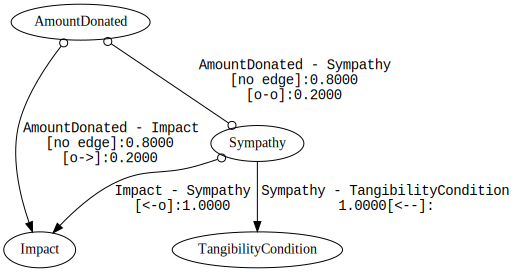

In [22]:
svg_str = graph.create_svg(prog='dot')
SVG(svg_str)

In [23]:
javabridge.detach()
javabridge.kill_vm()